## Determining the effect of different model output temporal resolutions
In this tutorial, we will using 2D surface currents to determine how different model output frequencies (15min, 1hr, and daily) effect the trajectories of particles in the North West Shelf.

<div class="alert alert-block alert-info">
<b>Note: </b> To run this example you will need to have the `copernicusmarine` toolbox isntalled.

</div>

In [1]:
# Library imports
from datetime import datetime, timedelta
import xarray as xr
import numpy as np

# parcels and plasticparcels imports
import os
os.chdir('../../')
print(os.getcwd())
import plasticparcels as pp
os.chdir('docs/examples/')

# Plotting imports
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature

/Users/denes001/Research/Projects/PlasticParcels/PlasticParcels


In [2]:
# Make a copernicus settings dictionary
settings_file = 'copernicus_marine.json'
settings = pp.utils.load_settings(settings_file)

In [3]:
# Download the mask and release data
# TODO: determine a way of constructing the release maps for copernicusmarine datasets
settings = pp.utils.download_plasticparcels_dataset('NEMO0083', settings, 'input_data')


/Users/denes001/Research/Projects/PlasticParcels/PlasticParcels/plasticparcels/utils.py:168: UserWarning: Could not set settings path ('unbeaching', 'filename') for dataset 'NEMO0083'.
  warnings.warn(f"Could not set settings path {settings_path} for dataset {dataset!r}.", stacklevel=1)


In [4]:
# Create the simulation settings
settings['simulation'] = {
    'startdate': datetime.strptime('2025-11-21-00:00:00', '%Y-%m-%d-%H:%M:%S'), # Start date of simulation
    'runtime': timedelta(days=5),        # Runtime of simulation
    'outputdt': timedelta(hours=1),      # Timestep of output
    'dt': timedelta(minutes=1),          # Timestep of advection
    # Specific to copernicusmarine datasets, provide a bounding box and depth range for your simulation
    'boundingbox': [-6.0, 11.0, 46.0, 62.0],  # Bounding box of simulation [lonmin, lonmax, latmin, latmax]}
    'depth_range': [0,2]#[0, 500],               # Depth range of simulation [depthmin, depthmax] in meters
}

# Turn off all processes except 2D advection
settings['use_3D'] = False
settings['use_wind'] = False
settings['use_stokes'] = False
settings['use_mixing'] = False
settings['use_biofouling'] = False

In [5]:
# Create the particle release settings
settings['release'] = {
    'initialisation_type': 'fisheries',
    'country': 'Netherlands',
}

In [6]:
# Create the plastic type settings
settings['plastictype'] = {
    'wind_coefficient' : 0.0,  # Percentage of wind to apply to particles
    'plastic_diameter' : 0.001, # Plastic particle diameter (m)
    'plastic_density' : 1028.,  # Plastic particle density (kg/m^3)
}

In [7]:
settings['ocean']['variables'] = {"U": "uo", "V": "vo"}

In [8]:
# Create different settings for 15min, 1hr and daily datasets
from copy import deepcopy
settings_15min = deepcopy(settings)
settings_1hr = deepcopy(settings)
settings_daily = deepcopy(settings)

In [9]:
settings_15min['ocean']['dimensions'].pop('depth')
settings_1hr['ocean']['dimensions'].pop('depth')

'depth'

In [10]:
# Point to the correct locations for each dataset
settings_15min['ocean']['dataset_id'].clear()
settings_15min['ocean']['dataset_id']['U'] = "cmems_mod_nws_phy_anfc_0.027deg-2D_PT15M-i"
settings_15min['ocean']['dataset_id']['V'] = "cmems_mod_nws_phy_anfc_0.027deg-2D_PT15M-i"
settings_15min['ocean']['dataset_id']['bathymetry'] = "cmems_mod_nws_phy_anfc_0.027deg-3D_static"

settings_1hr['ocean']['dataset_id'].clear()
settings_1hr['ocean']['dataset_id']['U'] = "cmems_mod_nws_phy_anfc_0.027deg-2D_PT1H-m"
settings_1hr['ocean']['dataset_id']['V'] = "cmems_mod_nws_phy_anfc_0.027deg-2D_PT1H-m"
settings_1hr['ocean']['dataset_id']['bathymetry'] = "cmems_mod_nws_phy_anfc_0.027deg-3D_static"

settings_daily['ocean']['dataset_id'].clear()
settings_daily['ocean']['dataset_id']['U'] = "cmems_mod_nws_phy_anfc_0.027deg-3D_P1D-m"
settings_daily['ocean']['dataset_id']['V'] = "cmems_mod_nws_phy_anfc_0.027deg-3D_P1D-m"
settings_daily['ocean']['dataset_id']['bathymetry'] = "cmems_mod_nws_phy_anfc_0.027deg-3D_static"


## Create a `FieldSet`, `ParticleSet` and `Kernel` list
Here we create the necessary `Parcels` objects to run our simulation. The `FieldSet` contains all the hydrodynamic, wind, and wave data required for our simulation. The `ParticleSet` is a set of particles initialised along the Italian coastline, and the `Kernel` list is a list of kernels that will be applied to these particles. A useful overview of these `Parcels` objects can be found [here](https://docs.parcels-code.org/en/latest/examples/tutorial_parcels_structure.html).

In [11]:
# Create the fieldset
fieldset_15min = pp.constructors.create_fieldset(settings_15min)
fieldset_1hr = pp.constructors.create_fieldset(settings_1hr)
fieldset_daily = pp.constructors.create_fieldset(settings_daily)

# Create the particleset
pset_15min = pp.constructors.create_particleset_from_map(fieldset_15min, settings_15min)
pset_1hr = pp.constructors.create_particleset_from_map(fieldset_1hr, settings_1hr)
pset_daily = pp.constructors.create_particleset_from_map(fieldset_daily, settings_daily)

# Create the applicable kernels to the plastic particles
kernels_15min = pp.constructors.create_kernel(fieldset_15min)
kernels_1hr = pp.constructors.create_kernel(fieldset_1hr)
kernels_daily = pp.constructors.create_kernel(fieldset_daily)

INFO - 2025-11-22T15:03:44Z - Selected dataset version: "202411"
INFO - 2025-11-22T15:03:44Z - Selected dataset part: "default"
WARNING - 2025-11-22T15:03:44Z - You are using the dataset cmems_mod_nws_phy_anfc_0.027deg-2D_PT15M-i, version '202411', part 'default'. This exact version and part of the dataset will be retired on the 2026-02-02T00:00:00.000Z. For more information you can check: https://marine.copernicus.eu/user-corner/product-roadmap/transition-information
WARNING - 2025-11-22T15:03:46Z - Some of your subset selection [46.0, 62.0] for the latitude dimension exceed the dataset coordinates [46.02707771, 61.277545579999995]
WARNING - 2025-11-22T15:03:46Z - Some of your subset selection [-6.0, 11.0] for the longitude dimension exceed the dataset coordinates [-15.99941317, 9.97360588]
INFO - 2025-11-22T15:03:47Z - Selected dataset version: "202411"
INFO - 2025-11-22T15:03:47Z - Selected dataset part: "default"
WARNING - 2025-11-22T15:03:47Z - You are using the dataset cmems_mod_

Define the runtime, the timestepping, and the output frequency of the simulation from the settings.

In [12]:
runtime = settings['simulation']['runtime']
dt = settings['simulation']['dt']
outputdt = settings['simulation']['outputdt']

In [13]:
kernels_15min

[<function plasticparcels.kernels.PolyTEOS10_bsq(particle, fieldset, time)>,
 <function parcels.application_kernels.advection.AdvectionRK4(particle, fieldset, time)>,
 <function plasticparcels.kernels.periodicBC(particle, fieldset, time)>,
 <function plasticparcels.kernels.deleteParticle(particle, fieldset, time)>]

In [14]:
# remove polyteos kernel
kernels_15min.pop(0)
kernels_1hr.pop(0)
kernels_daily.pop(0)


<function plasticparcels.kernels.PolyTEOS10_bsq(particle, fieldset, time)>

In [15]:
kernels_15min.append(pp.checkErrorThroughSurface)
kernels_1hr.append(pp.checkErrorThroughSurface)
kernels_daily.append(pp.checkErrorThroughSurface)

In [16]:
# Create the particle file where output will be stored
pfile_15min = pp.ParticleFile('example_cms_NWS_15min.zarr', pset_15min, settings=settings_15min, outputdt=outputdt)
pfile_1hr = pp.ParticleFile('example_cms_NWS_1hr.zarr', pset_1hr, settings=settings_1hr, outputdt=outputdt)
pfile_daily = pp.ParticleFile('example_cms_NWS_daily.zarr', pset_daily, settings=settings_daily, outputdt=outputdt)

# TODO: coastal might not match this model coast, it isn't the c-grid, so CHECK!

In [17]:
# Execute the simulation
pset_15min.execute(kernels_15min, runtime=runtime, dt=dt, output_file=pfile_15min)
pset_1hr.execute(kernels_1hr, runtime=runtime, dt=dt, output_file=pfile_1hr)
pset_daily.execute(kernels_daily, runtime=runtime, dt=dt, output_file=pfile_daily)

INFO: Output files are stored in example_cms_NWS_15min.zarr.
100%|██████████| 432000.0/432000.0 [01:58<00:00, 3652.35it/s] 
INFO: Output files are stored in example_cms_NWS_1hr.zarr.
100%|██████████| 432000.0/432000.0 [00:37<00:00, 11617.34it/s]
INFO: Output files are stored in example_cms_NWS_daily.zarr.
 80%|████████  | 345600.0/432000.0 [00:23<00:05, 15083.86it/s]WARNING: ParticleSet is empty on writing as array at time 345600
 94%|█████████▍| 406860.0/432000.0 [00:23<00:00, 105870.38it/s]WARNING: ParticleSet is empty on writing as array at time 410400
100%|██████████| 432000.0/432000.0 [00:23<00:00, 18049.96it/s] 


## Plot the trajectories
Finally, we produce a simple 'spaghetti' plot and and a concentration map of the trajectories to visualise their pathways. To understand how to work with `PlasticParcels` output, please see the `Parcels` tutorial [here](https://docs.parcels-code.org/en/latest/examples/tutorial_output.html).

/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/denes001/anaconda3/envs/py3_parcels/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


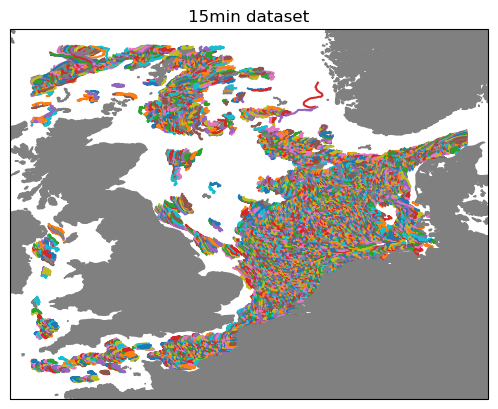

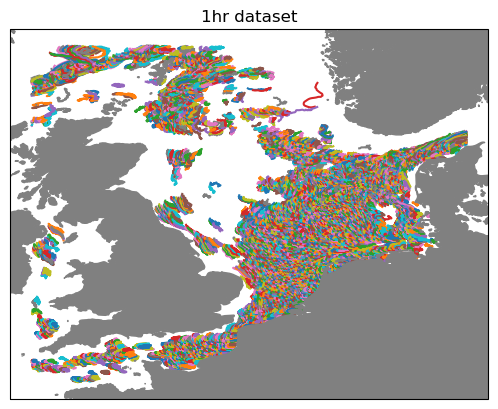

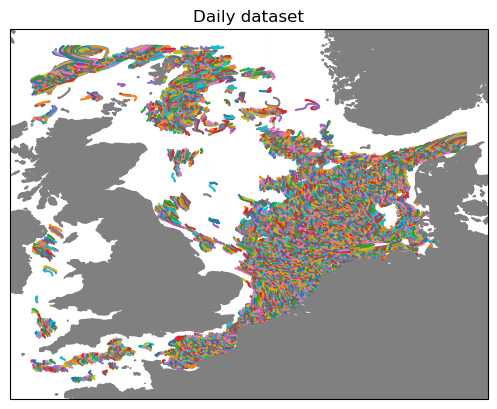

In [75]:
# Load the ParticleFile
ds_15min = xr.open_zarr('example_cms_NWS_15min.zarr')
ds_1hr = xr.open_zarr('example_cms_NWS_1hr.zarr')
ds_daily = xr.open_zarr('example_cms_NWS_daily.zarr')

ax = plt.subplot(111, projection= ccrs.PlateCarree())
ax.plot(ds_15min['lon'].T, ds_15min['lat'].T, transform=ccrs.PlateCarree(), zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, color='grey')
plt.title("15min dataset")
plt.show()

ax = plt.subplot(111, projection= ccrs.PlateCarree())
ax.plot(ds_1hr['lon'].T, ds_1hr['lat'].T, transform=ccrs.PlateCarree(), zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, color='grey')
plt.title("1hr dataset")
plt.show()

ax = plt.subplot(111, projection= ccrs.PlateCarree())
ax.plot(ds_daily['lon'].T, ds_daily['lat'].T, transform=ccrs.PlateCarree(), zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, color='grey')
plt.title("Daily dataset")
plt.show()

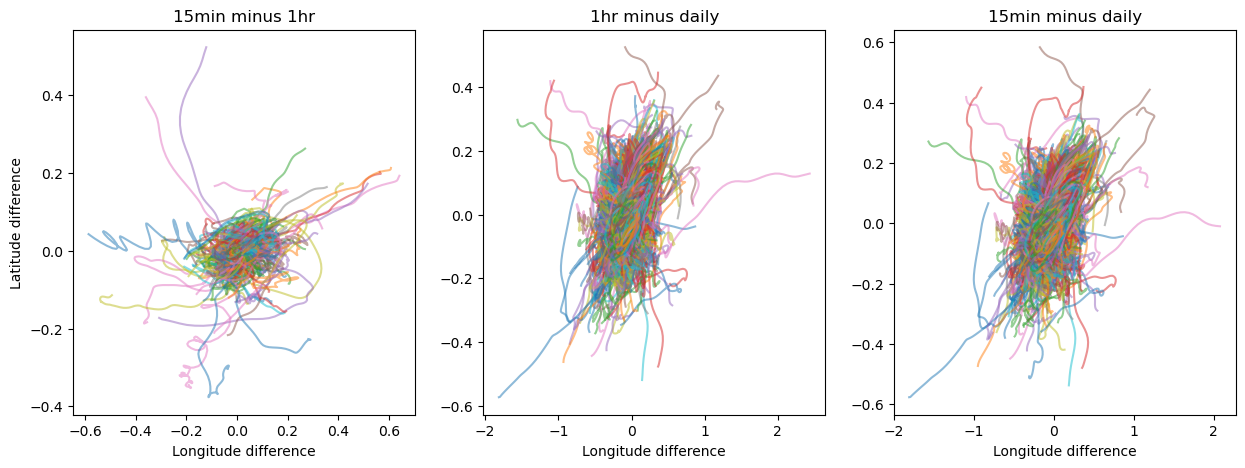

In [76]:
# Diff plot
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].set_title('15min minus 1hr')
axs[0].set_ylabel('Latitude difference')
axs[0].set_xlabel('Longitude difference')
im1 = axs[0].plot(ds_15min['lon'].T.values[:120] - ds_1hr['lon'].T.values, ds_15min['lat'].T.values[:120] - ds_1hr['lat'].T.values, alpha=0.5)
axs[1].set_title('1hr minus daily')
axs[1].set_xlabel('Longitude difference')
im3 = axs[1].plot(ds_1hr['lon'].T.values[:97] - ds_daily['lon'].T.values, ds_1hr['lat'].T.values[:97] - ds_daily['lat'].T.values, alpha=0.5)
axs[2].set_title('15min minus daily')
axs[2].set_xlabel('Longitude difference')
im5 = axs[2].plot(ds_15min['lon'].T.values[:97] - ds_daily['lon'].T.values, ds_15min['lat'].T.values[:97] - ds_daily['lat'].T.values, alpha=0.5)
plt.show()

In [32]:
def distance(lat1, lon1, lat2, lon2):
    R = 6371e3  # metres
    phi1 = lat1 * np.pi/180  # φ, λ in radians
    phi2 = lat2 * np.pi/180
    delta_phi = (lat2 - lat1) * np.pi/180
    delta_lambda = (lon2 - lon1) * np.pi/180

    a = np.sin(delta_phi/2) * np.sin(delta_phi/2) + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2) * np.sin(delta_lambda/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    d = R * c  # in metres
    return d/1000  # in km

In [33]:
distances_15min_1hr = distance(ds_15min['lat'].T.values[:120], ds_15min['lon'].T.values[:120], ds_1hr['lat'].T.values, ds_1hr['lon'].T.values)
distances_1hr_daily = distance(ds_1hr['lat'].T.values[:97], ds_1hr['lon'].T.values[:97], ds_daily['lat'].T.values, ds_daily['lon'].T.values)
distances_15min_daily = distance(ds_15min['lat'].T.values[:97], ds_15min['lon'].T.values[:97], ds_daily['lat'].T.values, ds_daily['lon'].T.values)


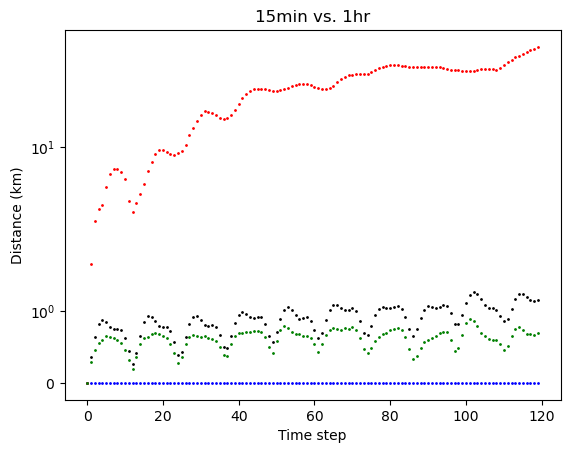

In [37]:
plt.title("15min vs. 1hr")
plt.scatter(range(len(distances_15min_1hr)), np.nanmean(distances_15min_1hr, axis=1), c='k', s=1)
plt.scatter(range(len(distances_15min_1hr)), np.nanmin(distances_15min_1hr, axis=1), c='b', s=1)
plt.scatter(range(len(distances_15min_1hr)), np.nanmax(distances_15min_1hr, axis=1), c='r', s=1)
plt.scatter(range(len(distances_15min_1hr)), np.nanmedian(distances_15min_1hr, axis=1), c='g', s=1)
plt.ylabel('Distance (km)')
plt.xlabel('Time step')
plt.yscale('symlog')


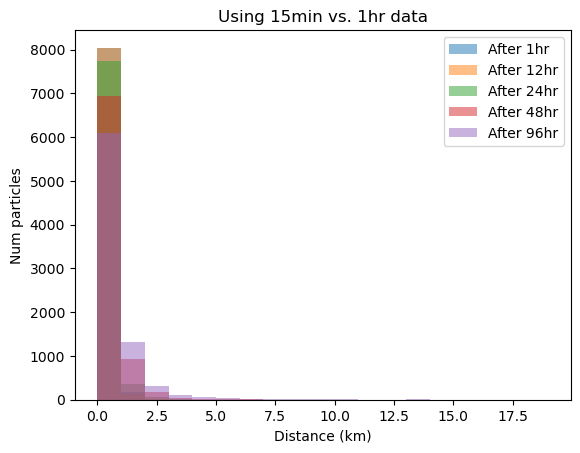

In [71]:
plt.hist(distances_15min_1hr[1], bins=np.arange(0,20), alpha=0.5, label='After 1hr')
plt.hist(distances_15min_1hr[12], bins=np.arange(0,20), alpha=0.5, label='After 12hr')
plt.hist(distances_15min_1hr[24], bins=np.arange(0,20), alpha=0.5, label='After 24hr')
plt.hist(distances_15min_1hr[48], bins=np.arange(0,20), alpha=0.5, label='After 48hr')
plt.hist(distances_15min_1hr[96], bins=np.arange(0,20), alpha=0.5, label='After 96hr')
plt.legend()
plt.title("Using 15min vs. 1hr data")
plt.xlabel('Distance (km)')
plt.ylabel('Num particles')
plt.show()

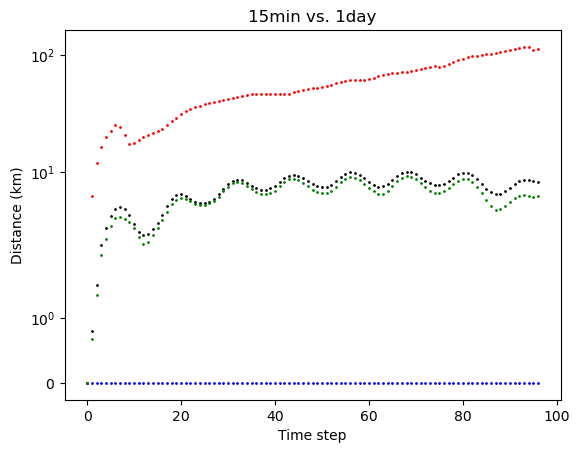

In [38]:
plt.title("15min vs. 1day")
plt.scatter(range(len(distances_15min_daily)), np.nanmean(distances_15min_daily, axis=1), c='k', s=1)
plt.scatter(range(len(distances_15min_daily)), np.nanmin(distances_15min_daily, axis=1), c='b', s=1)
plt.scatter(range(len(distances_15min_daily)), np.nanmax(distances_15min_daily, axis=1), c='r', s=1)
plt.scatter(range(len(distances_15min_daily)), np.nanmedian(distances_15min_daily, axis=1), c='g', s=1)
plt.ylabel('Distance (km)')
plt.xlabel('Time step')
plt.yscale('symlog')


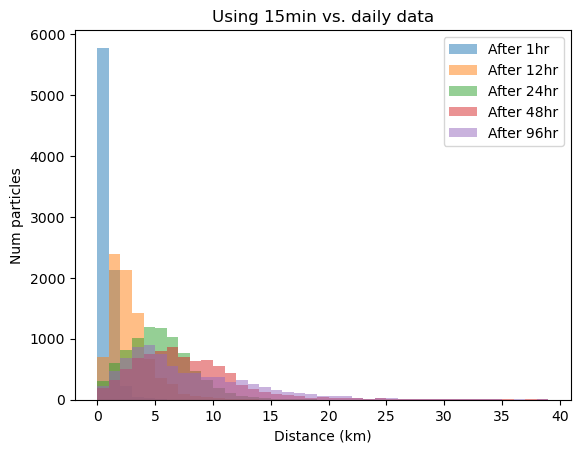

In [73]:
plt.hist(distances_15min_daily[1], bins=np.arange(0,40), alpha=0.5, label='After 1hr')
plt.hist(distances_15min_daily[12], bins=np.arange(0,40), alpha=0.5, label='After 12hr')
plt.hist(distances_15min_daily[24], bins=np.arange(0,40), alpha=0.5, label='After 24hr')
plt.hist(distances_15min_daily[48], bins=np.arange(0,40), alpha=0.5, label='After 48hr')
plt.hist(distances_15min_daily[96], bins=np.arange(0,40), alpha=0.5, label='After 96hr')
plt.legend()
plt.title("Using 15min vs. daily data")
plt.xlabel('Distance (km)')
plt.ylabel('Num particles')
plt.show()

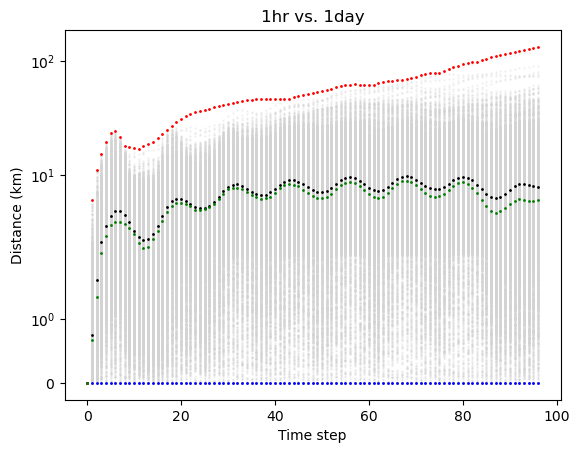

In [57]:
plt.title("1hr vs. 1day")
for i in range(0,len(distances_1hr_daily)):
    plt.scatter([i]*len(distances_1hr_daily[i][~np.isnan(distances_1hr_daily[i])]), distances_1hr_daily[i][~np.isnan(distances_1hr_daily[i])], c='lightgrey', s=0.5, alpha=0.25)
plt.scatter(range(len(distances_1hr_daily)), np.nanmean(distances_1hr_daily, axis=1), c='k', s=1)
plt.scatter(range(len(distances_1hr_daily)), np.nanmin(distances_1hr_daily, axis=1), c='b', s=1)
plt.scatter(range(len(distances_1hr_daily)), np.nanmax(distances_1hr_daily, axis=1), c='r', s=1)
plt.scatter(range(len(distances_1hr_daily)), np.nanmedian(distances_1hr_daily, axis=1), c='g', s=1)
plt.ylabel('Distance (km)')
plt.xlabel('Time step')
plt.yscale('symlog')


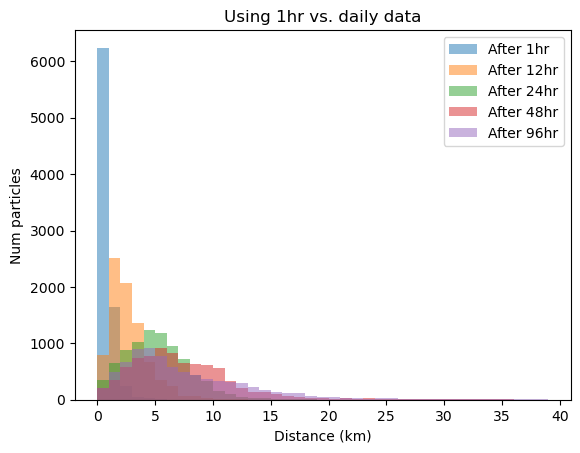

In [74]:
plt.hist(distances_1hr_daily[1], bins=np.arange(0,40), alpha=0.5, label='After 1hr')
plt.hist(distances_1hr_daily[12], bins=np.arange(0,40), alpha=0.5, label='After 12hr')
plt.hist(distances_1hr_daily[24], bins=np.arange(0,40), alpha=0.5, label='After 24hr')
plt.hist(distances_1hr_daily[48], bins=np.arange(0,40), alpha=0.5, label='After 48hr')
plt.hist(distances_1hr_daily[96], bins=np.arange(0,40), alpha=0.5, label='After 96hr')
plt.legend()
plt.title("Using 1hr vs. daily data")
plt.xlabel('Distance (km)')
plt.ylabel('Num particles')
plt.show()